# Study H1 ~ H50

In [1]:
%load_ext autoreload
%autoreload 2
#PROJ_HOME='/Users/skeem/Projects/analyst_performance/'

PROJ_HOME='/Users/skeem396/Projects/analyst_performance/'
import sys
sys.path.append(PROJ_HOME)
from datetime import datetime
from pathlib import Path
import matplotlib

## Import

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import copy
import pickle
from tqdm import tqdm

In [3]:
import spacy
#from spacytextblob.spacytextblob import SpacyTextBlob
#from googletrans import Translator

2023-10-08 22:44:26.788559: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
from arum.preprocessing import fix_price, get_author_production, clean_recommendations, change_col_names, build_labels
from arum.preprocessing import check_report_date, group_by_month
from arum.lookups.column_names import new_col_names

In [5]:
plt.rcParams["font.family"] = 'AppleMyungjo'
plt.rcParams["font.size"] = 9
plt.rcParams["figure.figsize"] = (16,4)

In [6]:
data_dir = Path(PROJ_HOME+'/data')

In [7]:
nlp = spacy.load("ko_core_news_lg")

In [8]:
#translator = Translator(service_urls=[
#      'translate.google.com',
#      'translate.google.co.kr',
#    ])

In [8]:
kospi = pd.read_csv(PROJ_HOME+'/data/kospi.csv')
kosdaq = pd.read_csv(PROJ_HOME+'/data/kosdaq.csv')

In [9]:
kospi_closing = kospi['종가'].to_list()
kosdaq_closing = kosdaq['종가'].to_list()

In [10]:
kospi['prev_closing'] = [1]+kospi_closing[:-1]
kosdaq['prev_closing'] = [1]+kosdaq_closing[:-1]

In [11]:
kospi

,날짜,시가,고가,저가,종가,prev_closing
0,2020-01-02,2201.21,2202.32,2171.84,2175.17,1.00
1,2020-01-03,2192.58,2203.38,2165.39,2176.46,2175.17
2,2020-01-06,2154.97,2164.42,2149.95,2155.07,2176.46
3,2020-01-07,2166.60,2181.62,2164.27,2175.54,2155.07
4,2020-01-08,2156.27,2162.32,2137.72,2151.31,2175.54
...,...,...,...,...,...,...
894,2023-08-11,2611.25,2616.84,2589.94,2591.26,2601.56
895,2023-08-14,2586.51,2592.91,2561.88,2570.87,2591.26
896,2023-08-16,2550.13,2550.53,2520.87,2525.64,2570.87
897,2023-08-17,2512.92,2520.56,2482.06,2519.85,2525.64


# Preprocessing

In [12]:
"""
    A1 = (발간일시가 - 전일종가) / 전일종가
    A2 = (고가 - 시가) / 시가
    A3 = (종가 - 시가) / 시가
"""
kospi['gap_up'] = kospi.apply(lambda x: (x['시가']-x['prev_closing'])/x['prev_closing'], axis=1) 
kospi['high_profit'] = kospi.apply(lambda x: (x['고가']-x['시가'])/x['시가'], axis=1)
kospi['closing_profit'] = kospi.apply(lambda x: (x['종가']-x['시가'])/x['시가'], axis=1)

kosdaq['gap_up'] = kosdaq.apply(lambda x: (x['시가']-x['prev_closing'])/x['prev_closing'], axis=1) 
kosdaq['high_profit'] = kosdaq.apply(lambda x: (x['고가']-x['시가'])/x['시가'], axis=1)
kosdaq['closing_profit'] = kosdaq.apply(lambda x: (x['종가']-x['시가'])/x['시가'], axis=1)


In [13]:
#sentiment_df = pd.read_pickle(PROJ_HOME+'/data/sentiment_pub_trade.pkl')
merged_df = pd.read_pickle(PROJ_HOME+'/data/merged.pkl')
merged_df

,index,Unnamed: 0,author,source,ticker_symbol,company,report_date,report_date-1,report_date-2,report_title,...,high,closing_1,closing_2,recommendation,H25,H50,A1,A2,A3,average
0,0,NaN,황현준,DB금융,A035420,NAVER,2020-01-14,2020-01-13,2020-01-10,앞으로가 중요하다,...,194500,188000,188000,BUY,194500,194500,0.000000,0.034574,0.013298,0.015957
1,1,NaN,황현준,DB금융,A034230,파라다이스,2020-01-16,2020-01-15,2020-01-14,4Q19 호실적 예상,...,21850,21600,21500,BUY,22000,22000,-0.002315,0.013921,0.011601,0.007736
2,2,NaN,황현준,DB금융,A039130,하나투어,2020-01-21,2020-01-20,2020-01-17,하반기를 기대,...,51968,52066,55094,BUY,51968,51968,-0.015019,0.013337,-0.009516,-0.003733
3,3,NaN,황현준,DB금융,A035720,카카오,2020-01-23,2020-01-22,2020-01-21,톡비즈보드가 실적 견인,...,33600,33200,33000,BUY,38300,38300,0.012048,0.000000,-0.014881,-0.000944
4,4,NaN,황현준,DB금융,A263750,펄어비스,2020-01-28,2020-01-23,2020-01-22,20년 하반기에 주목,...,38000,38660,36660,BUY,39200,39620,-0.031557,0.014957,-0.009081,-0.008560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63242,19782,NaN,강경근,NH,A032540,TJ미디어,2022-08-04,2022-08-03,2022-08-02,가무의 민족,...,6890,6330,6320,NR,6890,7120,0.028436,0.058372,-0.004608,0.027400
63243,19783,NaN,강경근,NH,A352940,인바이오,2022-08-31,2022-08-30,2022-08-29,"제네릭, 친환경 제품으로 성장 동력 확보",...,6040,6020,6050,NR,6040,6040,0.003322,0.000000,-0.013245,-0.003308
63244,19784,NaN,강경근,NH,A277810,레인보우로보틱스,2022-09-02,2022-09-01,2022-08-31,내가 로봇 대장주가 될 상인가?,...,31300,29100,30800,NR,39200,39200,0.027491,0.046823,0.006689,0.027001
63245,19785,NaN,강경근,NH,A294570,쿠콘,2022-11-16,2022-11-15,2022-11-14,금융 플랫폼 서비스 활성화 수혜,...,31500,29750,29000,NR,32500,35750,0.018487,0.039604,0.031353,0.029815


In [14]:
author_freq = get_author_production(merged_df)

In [15]:
clean_recommendations(merged_df)

{'BUY': 49627,
 'NR': 10147,
 'HOLD': 3317,
 'STRONG_BUY': 152,
 'SELL': 3,
 'REDUCE': 1}

In [16]:
merged_df.drop(['index', 'Unnamed: 0'], inplace=True, axis=1)

In [17]:
merged_df.query('recommendation != "SELL" and recommendation != "REDUCE"')

,author,source,ticker_symbol,company,report_date,report_date-1,report_date-2,report_title,opening,closing,high,closing_1,closing_2,recommendation,H25,H50,A1,A2,A3,average
0,황현준,DB금융,A035420,NAVER,2020-01-14,2020-01-13,2020-01-10,앞으로가 중요하다,188000,190500,194500,188000,188000,BUY,194500,194500,0.000000,0.034574,0.013298,0.015957
1,황현준,DB금융,A034230,파라다이스,2020-01-16,2020-01-15,2020-01-14,4Q19 호실적 예상,21550,21800,21850,21600,21500,BUY,22000,22000,-0.002315,0.013921,0.011601,0.007736
2,황현준,DB금융,A039130,하나투어,2020-01-21,2020-01-20,2020-01-17,하반기를 기대,51284,50796,51968,52066,55094,BUY,51968,51968,-0.015019,0.013337,-0.009516,-0.003733
3,황현준,DB금융,A035720,카카오,2020-01-23,2020-01-22,2020-01-21,톡비즈보드가 실적 견인,33600,33100,33600,33200,33000,BUY,38300,38300,0.012048,0.000000,-0.014881,-0.000944
4,황현준,DB금융,A263750,펄어비스,2020-01-28,2020-01-23,2020-01-22,20년 하반기에 주목,37440,37100,38000,38660,36660,BUY,39200,39620,-0.031557,0.014957,-0.009081,-0.008560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63242,강경근,NH,A032540,TJ미디어,2022-08-04,2022-08-03,2022-08-02,가무의 민족,6510,6480,6890,6330,6320,NR,6890,7120,0.028436,0.058372,-0.004608,0.027400
63243,강경근,NH,A352940,인바이오,2022-08-31,2022-08-30,2022-08-29,"제네릭, 친환경 제품으로 성장 동력 확보",6040,5960,6040,6020,6050,NR,6040,6040,0.003322,0.000000,-0.013245,-0.003308
63244,강경근,NH,A277810,레인보우로보틱스,2022-09-02,2022-09-01,2022-08-31,내가 로봇 대장주가 될 상인가?,29900,30100,31300,29100,30800,NR,39200,39200,0.027491,0.046823,0.006689,0.027001
63245,강경근,NH,A294570,쿠콘,2022-11-16,2022-11-15,2022-11-14,금융 플랫폼 서비스 활성화 수혜,30300,31250,31500,29750,29000,NR,32500,35750,0.018487,0.039604,0.031353,0.029815


In [18]:
#change_col_names(sentiment_df)

In [19]:
for colnm in list(new_col_names.values()):
    print(colnm)
    merged_df = fix_price(merged_df, colnm)

report_date-1
report_date-2
high
closing
opening
closing_1
closing_2


In [20]:
merged_df = fix_price(merged_df, 'H25')
merged_df = fix_price(merged_df, 'H50')

In [21]:
merged_df['report_date-2'].value_counts()

report_date-2
2020-05-14    330
2021-11-11    291
2020-08-13    285
2021-10-27    273
2021-05-13    257
             ... 
2022-09-14     19
2020-12-23     18
2022-12-23     16
2022-12-27     15
2020-12-24     12
Name: count, Length: 741, dtype: int64

In [22]:
#merged_df['report_date-2'].fillna('', inplace=True)

In [22]:
merged_df = check_report_date(merged_df)

In [23]:
# Sanity Check.  cnt_no should be 0
cnt_yes = 0
cnt_no = 0
for k, r in merged_df.iterrows():
    if type(r['report_date']) == datetime:
        cnt_yes += 1
    else:
        cnt_no += 1
print(cnt_yes, cnt_no)

0 63247


# Labeling

### Descriptions
1. __label1: positive gap-up
1. __label2: positive high profit
1. __label3: Positive closing profit
1. __label4: Positive for both gap-up and closing profit
1. __label5: Maintaining gap-up after 25 days
1. __label6: Maintaining gap-up after 50 days
1. __label7: Both H25 and H50 positive

In [25]:
labeled_df = build_labels(merged_df)

In [26]:
labeled_df

,author,source,ticker_symbol,company,report_date,report_date-1,report_date-2,report_title,opening,closing,...,__label1,__label2,__label3,__label4,__label5,__label6,__label7,gap_up_ratio,high_profit_ratio,closing_profit_ratio
0,황현준,DB금융,A035420,NAVER,2020-01-14,2020-01-13,2020-01-10,앞으로가 중요하다,188000,190500,...,0,1,1,0,0,0,0,0.000000,0.034574,0.013298
1,황현준,DB금융,A034230,파라다이스,2020-01-16,2020-01-15,2020-01-14,4Q19 호실적 예상,21550,21800,...,0,1,1,0,1,1,1,-0.002315,0.013921,0.011601
2,황현준,DB금융,A039130,하나투어,2020-01-21,2020-01-20,2020-01-17,하반기를 기대,51284,50796,...,0,1,0,0,0,0,0,-0.015019,0.013337,-0.009516
3,황현준,DB금융,A035720,카카오,2020-01-23,2020-01-22,2020-01-21,톡비즈보드가 실적 견인,33600,33100,...,1,0,0,0,1,1,1,0.012048,0.000000,-0.014881
4,황현준,DB금융,A263750,펄어비스,2020-01-28,2020-01-23,2020-01-22,20년 하반기에 주목,37440,37100,...,0,1,0,0,1,1,1,-0.031557,0.014957,-0.009081
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63242,강경근,NH,A032540,TJ미디어,2022-08-04,2022-08-03,2022-08-02,가무의 민족,6510,6480,...,1,1,0,0,0,1,0,0.028436,0.058372,-0.004608
63243,강경근,NH,A352940,인바이오,2022-08-31,2022-08-30,2022-08-29,"제네릭, 친환경 제품으로 성장 동력 확보",6040,5960,...,1,0,0,0,0,0,0,0.003322,0.000000,-0.013245
63244,강경근,NH,A277810,레인보우로보틱스,2022-09-02,2022-09-01,2022-08-31,내가 로봇 대장주가 될 상인가?,29900,30100,...,1,1,1,1,1,1,1,0.027491,0.046823,0.006689
63245,강경근,NH,A294570,쿠콘,2022-11-16,2022-11-15,2022-11-14,금융 플랫폼 서비스 활성화 수혜,30300,31250,...,1,1,1,1,1,1,1,0.018487,0.039604,0.031353


In [27]:
labeled_df.shape

(63247, 31)

In [28]:
# removing invalid data
valid_df = labeled_df.query('gap_up_ratio > -1 and high_profit_ratio > -1 and closing_profit_ratio > -1').copy()
valid_df.shape

(63247, 31)

In [29]:
valid_df[['A1', 'A2', 'A3', '__label1', '__label2', '__label3', '__label4', '__label5', '__label6', '__label7']]

,A1,A2,A3,__label1,__label2,__label3,__label4,__label5,__label6,__label7
0,0.000000,0.034574,0.013298,0,1,1,0,0,0,0
1,-0.002315,0.013921,0.011601,0,1,1,0,1,1,1
2,-0.015019,0.013337,-0.009516,0,1,0,0,0,0,0
3,0.012048,0.000000,-0.014881,1,0,0,0,1,1,1
4,-0.031557,0.014957,-0.009081,0,1,0,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...
63242,0.028436,0.058372,-0.004608,1,1,0,0,0,1,0
63243,0.003322,0.000000,-0.013245,1,0,0,0,0,0,0
63244,0.027491,0.046823,0.006689,1,1,1,1,1,1,1
63245,0.018487,0.039604,0.031353,1,1,1,1,1,1,1


# By Authors

In [30]:
valid_df.keys()

Index(['author', 'source', 'ticker_symbol', 'company', 'report_date',
       'report_date-1', 'report_date-2', 'report_title', 'opening', 'closing',
       'high', 'closing_1', 'closing_2', 'recommendation', 'H25', 'H50', 'A1',
       'A2', 'A3', 'average', 'report_month', '__label1', '__label2',
       '__label3', '__label4', '__label5', '__label6', '__label7',
       'gap_up_ratio', 'high_profit_ratio', 'closing_profit_ratio'],
      dtype='object')

In [31]:
valid_df.groupby('author').count()

,source,ticker_symbol,company,report_date,report_date-1,report_date-2,report_title,opening,closing,high,...,__label1,__label2,__label3,__label4,__label5,__label6,__label7,gap_up_ratio,high_profit_ratio,closing_profit_ratio
author,,,,,,,,,,,,,,,,,,,,,
강경근,59,59,59,59,59,59,59,59,59,59,...,59,59,59,59,59,59,59,59,59,59
강경태,103,103,103,103,103,103,103,103,103,103,...,103,103,103,103,103,103,103,103,103,103
강동근,31,31,31,31,31,31,31,31,31,31,...,31,31,31,31,31,31,31,31,31,31
강동진,280,280,280,280,280,280,280,280,280,280,...,280,280,280,280,280,280,280,280,280,280
강석오,107,107,107,107,107,107,107,107,107,107,...,107,107,107,107,107,107,107,107,107,107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
황성환,70,70,70,70,70,70,70,70,70,70,...,70,70,70,70,70,70,70,70,70,70
황승택,59,59,59,59,59,59,59,59,59,59,...,59,59,59,59,59,59,59,59,59,59
황어연,177,177,177,177,177,177,177,177,177,177,...,177,177,177,177,177,177,177,177,177,177


In [34]:
valid_df.groupby('author').count()['source']

author
강경근     59
강경태    103
강동근     31
강동진    280
강석오    107
      ... 
황성환     70
황승택     59
황어연    177
황유식    120
황현준    142
Name: source, Length: 590, dtype: int64

In [35]:
label_sum_ratio_df = valid_df[['author', '__label1', '__label2', '__label3', '__label4', '__label5', '__label6', '__label7']].groupby('author').sum()
label_sum_ratio_df['total_reports'] = valid_df.groupby('author').count()['source']

In [36]:
label_sum_ratio_df

,__label1,__label2,__label3,__label4,__label5,__label6,__label7,total_reports
author,,,,,,,,
강경근,41,53,33,25,46,49,46,59
강경태,64,95,52,32,80,85,80,103
강동근,20,28,13,4,23,24,23,31
강동진,174,253,116,69,241,256,241,280
강석오,51,93,41,20,89,91,89,107
...,...,...,...,...,...,...,...,...
황성환,50,63,33,22,57,63,57,70
황승택,36,52,28,15,53,54,53,59
황어연,108,163,69,49,147,158,147,177


In [37]:

performance_indicator_df = valid_df[['author', 'A1', 'A2', 'A3']].groupby('author').mean().copy() 
#.sort_values(['1st_time_delta'], ascending=True).copy()
performance_indicator_df

,A1,A2,A3
author,,,
강경근,0.016612,0.041757,0.008223
강경태,0.001674,0.020360,0.001196
강동근,0.010517,0.047562,0.011273
강동진,0.004725,0.021228,-0.000468
강석오,0.001147,0.020642,-0.009358
...,...,...,...
황성환,0.009341,0.028252,-0.000234
황승택,0.004298,0.026864,0.007460
황어연,0.004366,0.021831,-0.005392


In [38]:
perf_merged = pd.concat([valid_df.groupby('author').count()[['source']].copy(), label_sum_ratio_df, performance_indicator_df], axis=1)

In [39]:
perf_merged['a1_hit_ratio'] = perf_merged.apply(lambda x: x['__label1']/x['source'], axis=1)
perf_merged['a2_hit_ratio'] = perf_merged.apply(lambda x: x['__label2']/x['source'], axis=1)
perf_merged['a3_hit_ratio'] = perf_merged.apply(lambda x: x['__label3']/x['source'], axis=1)
perf_merged['L4_hit_ratio'] = perf_merged.apply(lambda x: x['__label4']/x['source'], axis=1)
perf_merged['L5_hit_ratio'] = perf_merged.apply(lambda x: x['__label5']/x['source'], axis=1)
perf_merged['L6_hit_ratio'] = perf_merged.apply(lambda x: x['__label6']/x['source'], axis=1)
perf_merged['L7_hit_ratio'] = perf_merged.apply(lambda x: x['__label7']/x['source'], axis=1)
perf_merged

,source,__label1,__label2,__label3,__label4,__label5,__label6,__label7,total_reports,A1,A2,A3,a1_hit_ratio,a2_hit_ratio,a3_hit_ratio,L4_hit_ratio,L5_hit_ratio,L6_hit_ratio,L7_hit_ratio
author,,,,,,,,,,,,,,,,,,,
강경근,59,41,53,33,25,46,49,46,59,0.016612,0.041757,0.008223,0.694915,0.898305,0.559322,0.423729,0.779661,0.830508,0.779661
강경태,103,64,95,52,32,80,85,80,103,0.001674,0.020360,0.001196,0.621359,0.922330,0.504854,0.310680,0.776699,0.825243,0.776699
강동근,31,20,28,13,4,23,24,23,31,0.010517,0.047562,0.011273,0.645161,0.903226,0.419355,0.129032,0.741935,0.774194,0.741935
강동진,280,174,253,116,69,241,256,241,280,0.004725,0.021228,-0.000468,0.621429,0.903571,0.414286,0.246429,0.860714,0.914286,0.860714
강석오,107,51,93,41,20,89,91,89,107,0.001147,0.020642,-0.009358,0.476636,0.869159,0.383178,0.186916,0.831776,0.850467,0.831776
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
황성환,70,50,63,33,22,57,63,57,70,0.009341,0.028252,-0.000234,0.714286,0.900000,0.471429,0.314286,0.814286,0.900000,0.814286
황승택,59,36,52,28,15,53,54,53,59,0.004298,0.026864,0.007460,0.610169,0.881356,0.474576,0.254237,0.898305,0.915254,0.898305
황어연,177,108,163,69,49,147,158,147,177,0.004366,0.021831,-0.005392,0.610169,0.920904,0.389831,0.276836,0.830508,0.892655,0.830508


In [42]:
perf_merged.to_excel(data_dir/'perf_merged.xls')

In [59]:
satisfied_perf_df = perf_merged.query('source > 20')
rising_perf_df = perf_merged.query('source <= 20 and source > 10')
under_perf_df = perf_merged.query('source <= 10')

In [60]:
satisfied_perf_df.sort_values('a1_hit_ratio', ascending=False)

,source,__label1,__label2,__label3,__label4,__label5,__label6,__label7,total_reports,A1,A2,A3,a1_hit_ratio,a2_hit_ratio,a3_hit_ratio,L4_hit_ratio,L5_hit_ratio,L6_hit_ratio,L7_hit_ratio
author,,,,,,,,,,,,,,,,,,,
김도윤,23,21,18,11,10,18,19,18,23,0.036334,0.053461,0.009436,0.913043,0.782609,0.478261,0.434783,0.782609,0.826087,0.782609
김규상,30,27,27,12,11,16,20,16,30,0.029239,0.032522,-0.008807,0.900000,0.900000,0.400000,0.366667,0.533333,0.666667,0.533333
양형모,44,39,41,23,19,38,41,38,44,0.027330,0.038713,0.004681,0.886364,0.931818,0.522727,0.431818,0.863636,0.931818,0.863636
이새롬,33,29,28,19,17,27,27,27,33,0.020711,0.033074,0.005687,0.878788,0.848485,0.575758,0.515152,0.818182,0.818182,0.818182
김승회,41,35,38,14,13,37,37,37,41,0.011159,0.020627,-0.001282,0.853659,0.926829,0.341463,0.317073,0.902439,0.902439,0.902439
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
조영환,44,14,38,21,4,34,39,34,44,-0.003324,0.017301,0.001923,0.318182,0.863636,0.477273,0.090909,0.772727,0.886364,0.772727
이한결,21,6,21,12,2,21,21,21,21,-0.001342,0.027128,0.008206,0.285714,1.000000,0.571429,0.095238,1.000000,1.000000,1.000000
김동우,46,13,41,14,6,38,39,38,46,-0.005028,0.018859,-0.006583,0.282609,0.891304,0.304348,0.130435,0.826087,0.847826,0.826087


In [51]:
valid_df['__label1'].value_counts()

__label1
1    37508
0    25739
Name: count, dtype: int64

In [52]:
valid_df['__label2'].value_counts()

__label2
1    57456
0     5791
Name: count, dtype: int64

In [53]:
valid_df['__label3'].value_counts()

__label3
0    34850
1    28397
Name: count, dtype: int64

In [54]:
valid_df['__label4'].value_counts()

__label4
0    46538
1    16709
Name: count, dtype: int64

In [55]:
valid_df['__label5'].value_counts()

__label5
1    52939
0    10308
Name: count, dtype: int64

In [66]:
satisfied_perf_df.sort_values('a1_hit_ratio', ascending=False)

,source,__label1,__label2,__label3,__label4,__label5,__label6,__label7,total_reports,A1,A2,A3,a1_hit_ratio,a2_hit_ratio,a3_hit_ratio,L4_hit_ratio,L5_hit_ratio,L6_hit_ratio,L7_hit_ratio
author,,,,,,,,,,,,,,,,,,,
김도윤,23,21,18,11,10,18,19,18,23,0.036334,0.053461,0.009436,0.913043,0.782609,0.478261,0.434783,0.782609,0.826087,0.782609
김규상,30,27,27,12,11,16,20,16,30,0.029239,0.032522,-0.008807,0.900000,0.900000,0.400000,0.366667,0.533333,0.666667,0.533333
양형모,44,39,41,23,19,38,41,38,44,0.027330,0.038713,0.004681,0.886364,0.931818,0.522727,0.431818,0.863636,0.931818,0.863636
이새롬,33,29,28,19,17,27,27,27,33,0.020711,0.033074,0.005687,0.878788,0.848485,0.575758,0.515152,0.818182,0.818182,0.818182
김승회,41,35,38,14,13,37,37,37,41,0.011159,0.020627,-0.001282,0.853659,0.926829,0.341463,0.317073,0.902439,0.902439,0.902439
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
조영환,44,14,38,21,4,34,39,34,44,-0.003324,0.017301,0.001923,0.318182,0.863636,0.477273,0.090909,0.772727,0.886364,0.772727
이한결,21,6,21,12,2,21,21,21,21,-0.001342,0.027128,0.008206,0.285714,1.000000,0.571429,0.095238,1.000000,1.000000,1.000000
김동우,46,13,41,14,6,38,39,38,46,-0.005028,0.018859,-0.006583,0.282609,0.891304,0.304348,0.130435,0.826087,0.847826,0.826087


In [68]:
satisfied_perf_df.sort_values('a2_hit_ratio', ascending=False)

,source,__label1,__label2,__label3,__label4,__label5,__label6,__label7,total_reports,A1,A2,A3,a1_hit_ratio,a2_hit_ratio,a3_hit_ratio,L4_hit_ratio,L5_hit_ratio,L6_hit_ratio,L7_hit_ratio
author,,,,,,,,,,,,,,,,,,,
최석원,22,11,22,10,4,19,21,19,22,-0.001425,0.024421,-0.006234,0.500000,1.000000,0.454545,0.181818,0.863636,0.954545,0.863636
허지수,22,11,22,10,6,20,21,20,22,-0.004171,0.020518,0.001050,0.500000,1.000000,0.454545,0.272727,0.909091,0.954545,0.909091
정우창,21,9,21,10,5,17,18,17,21,0.000539,0.034434,0.006930,0.428571,1.000000,0.476190,0.238095,0.809524,0.857143,0.809524
유경하,36,23,36,19,10,32,33,32,36,0.008163,0.024923,0.003865,0.638889,1.000000,0.527778,0.277778,0.888889,0.916667,0.888889
전창현,58,43,58,26,22,53,57,53,58,0.004479,0.024244,0.004796,0.741379,1.000000,0.448276,0.379310,0.913793,0.982759,0.913793
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
위해주,25,14,20,10,5,22,22,22,25,0.004005,0.017797,-0.014120,0.560000,0.800000,0.400000,0.200000,0.880000,0.880000,0.880000
김도윤,23,21,18,11,10,18,19,18,23,0.036334,0.053461,0.009436,0.913043,0.782609,0.478261,0.434783,0.782609,0.826087,0.782609
김영건,91,30,70,23,7,57,58,57,91,-0.001542,0.009611,-0.009806,0.329670,0.769231,0.252747,0.076923,0.626374,0.637363,0.626374


In [69]:
satisfied_perf_df.sort_values('a3_hit_ratio', ascending=False)

,source,__label1,__label2,__label3,__label4,__label5,__label6,__label7,total_reports,A1,A2,A3,a1_hit_ratio,a2_hit_ratio,a3_hit_ratio,L4_hit_ratio,L5_hit_ratio,L6_hit_ratio,L7_hit_ratio
author,,,,,,,,,,,,,,,,,,,
채상욱,31,14,30,23,10,24,26,24,31,0.002482,0.025600,0.007652,0.451613,0.967742,0.741935,0.322581,0.774194,0.838710,0.774194
이승철,34,16,33,24,11,33,33,33,34,0.002731,0.055112,0.025503,0.470588,0.970588,0.705882,0.323529,0.970588,0.970588,0.970588
임예림,43,30,43,28,18,35,38,35,43,0.010043,0.044201,0.019450,0.697674,1.000000,0.651163,0.418605,0.813953,0.883721,0.813953
손지우,33,19,29,21,8,32,32,32,33,-0.006088,0.035702,0.019081,0.575758,0.878788,0.636364,0.242424,0.969697,0.969697,0.969697
심의섭,33,23,31,21,17,28,28,28,33,0.012296,0.051874,0.020812,0.696970,0.939394,0.636364,0.515152,0.848485,0.848485,0.848485
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
엄태웅,35,20,32,10,4,28,30,28,35,0.004470,0.024681,-0.000438,0.571429,0.914286,0.285714,0.114286,0.800000,0.857143,0.800000
윤주호,35,16,28,10,6,28,30,28,35,0.008698,0.032566,-0.011551,0.457143,0.800000,0.285714,0.171429,0.800000,0.857143,0.800000
이혜인,40,30,39,11,8,30,32,30,40,0.008296,0.017398,-0.014658,0.750000,0.975000,0.275000,0.200000,0.750000,0.800000,0.750000


In [61]:
satisfied_perf_df.sort_values('L4_hit_ratio', ascending=False)

,source,__label1,__label2,__label3,__label4,__label5,__label6,__label7,total_reports,A1,A2,A3,a1_hit_ratio,a2_hit_ratio,a3_hit_ratio,L4_hit_ratio,L5_hit_ratio,L6_hit_ratio,L7_hit_ratio
author,,,,,,,,,,,,,,,,,,,
심의섭,33,23,31,21,17,28,28,28,33,0.012296,0.051874,0.020812,0.696970,0.939394,0.636364,0.515152,0.848485,0.848485,0.848485
이새롬,33,29,28,19,17,27,27,27,33,0.020711,0.033074,0.005687,0.878788,0.848485,0.575758,0.515152,0.818182,0.818182,0.818182
최영산,37,29,35,21,18,37,37,37,37,0.020664,0.038152,0.012912,0.783784,0.945946,0.567568,0.486486,1.000000,1.000000,1.000000
이수림,26,19,23,15,12,21,22,21,26,0.004836,0.026704,-0.001975,0.730769,0.884615,0.576923,0.461538,0.807692,0.846154,0.807692
조태나,34,29,30,17,15,27,30,27,34,0.011931,0.035352,0.007397,0.852941,0.882353,0.500000,0.441176,0.794118,0.882353,0.794118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
조용선,30,18,28,7,3,23,25,23,30,0.004837,0.017706,-0.006067,0.600000,0.933333,0.233333,0.100000,0.766667,0.833333,0.766667
이한결,21,6,21,12,2,21,21,21,21,-0.001342,0.027128,0.008206,0.285714,1.000000,0.571429,0.095238,1.000000,1.000000,1.000000
조영환,44,14,38,21,4,34,39,34,44,-0.003324,0.017301,0.001923,0.318182,0.863636,0.477273,0.090909,0.772727,0.886364,0.772727


In [70]:
satisfied_perf_df.sort_values('L5_hit_ratio', ascending=False)

,source,__label1,__label2,__label3,__label4,__label5,__label6,__label7,total_reports,A1,A2,A3,a1_hit_ratio,a2_hit_ratio,a3_hit_ratio,L4_hit_ratio,L5_hit_ratio,L6_hit_ratio,L7_hit_ratio
author,,,,,,,,,,,,,,,,,,,
최영산,37,29,35,21,18,37,37,37,37,0.020664,0.038152,0.012912,0.783784,0.945946,0.567568,0.486486,1.000000,1.000000,1.000000
이한결,21,6,21,12,2,21,21,21,21,-0.001342,0.027128,0.008206,0.285714,1.000000,0.571429,0.095238,1.000000,1.000000,1.000000
문정윤,21,11,19,12,3,21,21,21,21,0.001197,0.030615,0.016523,0.523810,0.904762,0.571429,0.142857,1.000000,1.000000,1.000000
이승철,34,16,33,24,11,33,33,33,34,0.002731,0.055112,0.025503,0.470588,0.970588,0.705882,0.323529,0.970588,0.970588,0.970588
손지우,33,19,29,21,8,32,32,32,33,-0.006088,0.035702,0.019081,0.575758,0.878788,0.636364,0.242424,0.969697,0.969697,0.969697
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
최윤희,42,16,38,19,7,29,31,29,42,-0.001132,0.011988,-0.004946,0.380952,0.904762,0.452381,0.166667,0.690476,0.738095,0.690476
정재원,24,14,21,11,6,16,17,16,24,0.003393,0.024984,0.002000,0.583333,0.875000,0.458333,0.250000,0.666667,0.708333,0.666667
김영건,91,30,70,23,7,57,58,57,91,-0.001542,0.009611,-0.009806,0.329670,0.769231,0.252747,0.076923,0.626374,0.637363,0.626374


In [71]:
satisfied_perf_df.sort_values('L6_hit_ratio', ascending=False)

,source,__label1,__label2,__label3,__label4,__label5,__label6,__label7,total_reports,A1,A2,A3,a1_hit_ratio,a2_hit_ratio,a3_hit_ratio,L4_hit_ratio,L5_hit_ratio,L6_hit_ratio,L7_hit_ratio
author,,,,,,,,,,,,,,,,,,,
이한결,21,6,21,12,2,21,21,21,21,-0.001342,0.027128,0.008206,0.285714,1.000000,0.571429,0.095238,1.000000,1.000000,1.000000
최영산,37,29,35,21,18,37,37,37,37,0.020664,0.038152,0.012912,0.783784,0.945946,0.567568,0.486486,1.000000,1.000000,1.000000
문정윤,21,11,19,12,3,21,21,21,21,0.001197,0.030615,0.016523,0.523810,0.904762,0.571429,0.142857,1.000000,1.000000,1.000000
오의림,38,21,32,14,7,36,38,36,38,0.003834,0.020003,-0.003064,0.552632,0.842105,0.368421,0.184211,0.947368,1.000000,0.947368
고문영,23,10,21,12,2,22,23,22,23,-0.003378,0.036467,0.015713,0.434783,0.913043,0.521739,0.086957,0.956522,1.000000,0.956522
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
최윤희,42,16,38,19,7,29,31,29,42,-0.001132,0.011988,-0.004946,0.380952,0.904762,0.452381,0.166667,0.690476,0.738095,0.690476
전영현,40,17,35,23,10,29,29,29,40,-0.003085,0.022437,0.006125,0.425000,0.875000,0.575000,0.250000,0.725000,0.725000,0.725000
정재원,24,14,21,11,6,16,17,16,24,0.003393,0.024984,0.002000,0.583333,0.875000,0.458333,0.250000,0.666667,0.708333,0.666667


In [72]:
satisfied_perf_df.sort_values('L7_hit_ratio', ascending=False)

,source,__label1,__label2,__label3,__label4,__label5,__label6,__label7,total_reports,A1,A2,A3,a1_hit_ratio,a2_hit_ratio,a3_hit_ratio,L4_hit_ratio,L5_hit_ratio,L6_hit_ratio,L7_hit_ratio
author,,,,,,,,,,,,,,,,,,,
최영산,37,29,35,21,18,37,37,37,37,0.020664,0.038152,0.012912,0.783784,0.945946,0.567568,0.486486,1.000000,1.000000,1.000000
이한결,21,6,21,12,2,21,21,21,21,-0.001342,0.027128,0.008206,0.285714,1.000000,0.571429,0.095238,1.000000,1.000000,1.000000
문정윤,21,11,19,12,3,21,21,21,21,0.001197,0.030615,0.016523,0.523810,0.904762,0.571429,0.142857,1.000000,1.000000,1.000000
이승철,34,16,33,24,11,33,33,33,34,0.002731,0.055112,0.025503,0.470588,0.970588,0.705882,0.323529,0.970588,0.970588,0.970588
손지우,33,19,29,21,8,32,32,32,33,-0.006088,0.035702,0.019081,0.575758,0.878788,0.636364,0.242424,0.969697,0.969697,0.969697
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
최윤희,42,16,38,19,7,29,31,29,42,-0.001132,0.011988,-0.004946,0.380952,0.904762,0.452381,0.166667,0.690476,0.738095,0.690476
정재원,24,14,21,11,6,16,17,16,24,0.003393,0.024984,0.002000,0.583333,0.875000,0.458333,0.250000,0.666667,0.708333,0.666667
김영건,91,30,70,23,7,57,58,57,91,-0.001542,0.009611,-0.009806,0.329670,0.769231,0.252747,0.076923,0.626374,0.637363,0.626374


/Users/skeem396/base38/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


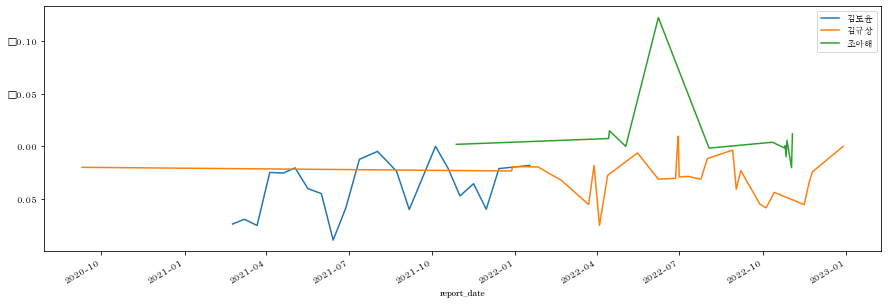

In [67]:
by_author_df = valid_df[['author', 'report_date', 'A1', 'A2','A3']].groupby(['author', 'report_date']).mean()
by_author_df = by_author_df.reset_index()

cnt = 0
fig, ax = plt.subplots()
leg = []
top_performers = ['김도윤', '김규상', '조아해']
for auth in top_performers[:5]:
    #leg.append(translator.translate(auth , src="ko", dest="en").text)
    leg.append(auth)
    tmp_df = by_author_df.loc[by_author_df['author'] == auth]
    tmp_df.set_index('report_date')['A1'].plot.line(legend=True, figsize=(15,5), ax=ax).invert_yaxis()
    cnt += 1
    #ax.set_xticklabels(list(valid_df['report_month'].unique()))
    ax.legend(leg)
    if cnt > 10:
        break

In [65]:
long_top5 = ['유욱재', 
'김태엽',
'오병용',
'전상용',
'고문영']
long_bot5 = ['이남석',
'김아람',
'신윤철',
'최윤희',
'임수연',
]

In [66]:
compare_df = valid_df.loc[valid_df['author'].isin(long_top5+long_bot5)][['author', 'report_date', 'A1']]

In [67]:
by_author_df = valid_df[['author', 'report_date', 'A1', 'A2','A3']].groupby(['author', 'report_date']).mean()

In [68]:
compare_df.loc[compare_df['author']=='유욱재']

,author,report_date,A1
9713,유욱재,2020-07-30,0.011111
9714,유욱재,2020-08-11,0.019560
9715,유욱재,2020-08-27,0.011029
9716,유욱재,2020-08-27,0.013528
9717,유욱재,2020-09-14,0.031847
9718,유욱재,2020-10-28,0.021157
9719,유욱재,2020-11-06,0.003356
9720,유욱재,2020-11-26,0.018957
9721,유욱재,2020-11-26,0.005089
9722,유욱재,2020-11-27,0.003895


In [69]:
by_author_df = by_author_df.reset_index()
by_author_df

,author,report_date,A1,A2,A3
0,강경근,2020-04-20,0.017094,0.056723,0.029412
1,강경근,2020-06-02,0.006829,0.017372,-0.002860
2,강경근,2020-06-08,0.021277,0.098958,0.015625
3,강경근,2020-09-08,0.003424,0.018750,-0.025556
4,강경근,2020-09-28,0.045114,0.037883,0.021038
...,...,...,...,...,...
40466,황현준,2022-11-10,-0.023068,0.001181,-0.061393
40467,황현준,2022-11-11,0.052083,0.123762,0.123762
40468,황현준,2022-11-14,-0.032840,0.001273,-0.068497
40469,황현준,2022-11-15,0.013678,0.025487,0.020990


In [70]:
a123_stats = by_author_df[['A1', 'A2', 'A3']].describe().to_dict()

In [71]:
two_sigma = a123_stats['A1']['std']*2
top_2sigma = a123_stats['A1']['mean']+two_sigma
bot_2sigma = a123_stats['A1']['mean']-two_sigma
top_2sigma, bot_2sigma

(0.05111087670432543, -0.03827747543427189)

In [72]:
top_performers = by_author_df.loc[by_author_df['A1']>top_2sigma]
top_performers

,author,report_date,A1,A2,A3
11,강경근,2021-07-06,0.140389,0.138258,0.041667
13,강경근,2021-08-05,0.080386,0.008929,-0.026786
15,강경근,2021-08-24,0.051163,0.066372,-0.011062
48,강경근,2022-12-29,0.061983,0.000000,-0.050584
84,강경태,2021-12-29,0.057416,0.180995,0.095023
...,...,...,...,...,...
40168,황어연,2020-08-07,0.132597,0.021892,-0.068319
40272,황유식,2020-03-27,0.069070,0.022472,-0.025279
40391,황현준,2020-12-03,0.175932,0.067624,-0.096948
40450,황현준,2022-05-17,0.058728,0.077042,0.058552


In [73]:
top_performers['author'].value_counts()[:10]

author
최재호    31
이동건    16
이동욱    15
김두현    14
선민정    13
김재윤    12
윤재성    11
허혜민    11
김홍식    11
최성환    10
Name: count, dtype: int64

In [74]:
bot_performers = by_author_df.loc[by_author_df['A1']<bot_2sigma]
bot_performers

,author,report_date,A1,A2,A3
158,강동진,2020-03-23,-0.084404,0.148297,0.074148
166,강동진,2020-04-28,-0.040559,0.024781,0.001458
176,강동진,2020-06-12,-0.058185,0.138245,0.088239
420,강성진,2020-06-12,-0.044000,0.020921,-0.010460
733,강하나,2021-11-15,-0.041667,0.004348,-0.073913
...,...,...,...,...,...
40063,황성환,2022-02-22,-0.046732,0.046853,0.025533
40144,황어연,2020-01-28,-0.049689,0.016340,-0.019608
40166,황어연,2020-08-03,-0.041993,0.011105,-0.020066
40211,황어연,2021-05-06,-0.209483,0.134289,0.059977


In [75]:
bot_performers['author'].value_counts()[:10]

author
오동환    8
서근희    7
박신애    7
오린아    6
배송이    6
김혜미    6
김현용    6
박은경    6
안지영    5
엄경아    5
Name: count, dtype: int64

# To study
1. Group higher than 10 and lower than 10: higher than 10 규정 타석, lower than 10 규정타석 미달 [v]
1. check how batters are ranked: pos/(pos+neg) -> 타율 비슷한 개념 [v]
1. check the delta of A1, A2, A3: repeat labeling after removing very small A1, A2, A3
1. label1+label2+label3 (0, 1, 2, 3)
1. label4 (A1>0 and A3>0) and H25up -> label5
1. label5>0 and H50up-> label6

## Adjust with Market bias
1. true_A1: A1 > 0 even if market gap-up is negative 
1. true_A2: A2 > 0 even if maret open-profit is negative
1. true_A3: A3 > 0 even if market closing-profit is negative

## Top performer simulation
1. 2023-06 training -> 2023-7,8 blind test  => compute profits
2. Rising star -> recent performer and delta is growing 
3. Study analyst interests -> forecast what the analyst will wrirte about

## Distributions A1, A2, A3

array([[<AxesSubplot:title={'center':'A1'}>]], dtype=object)

/Users/skeem396/base38/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


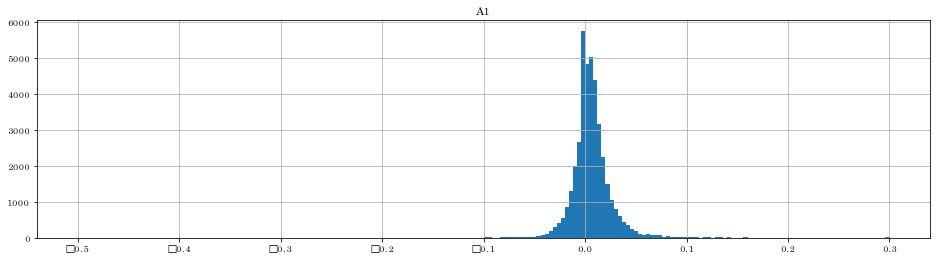

In [82]:
by_author_df[['A1']].hist(bins=200)

array([[<AxesSubplot:title={'center':'A1'}>]], dtype=object)

/Users/skeem396/base38/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


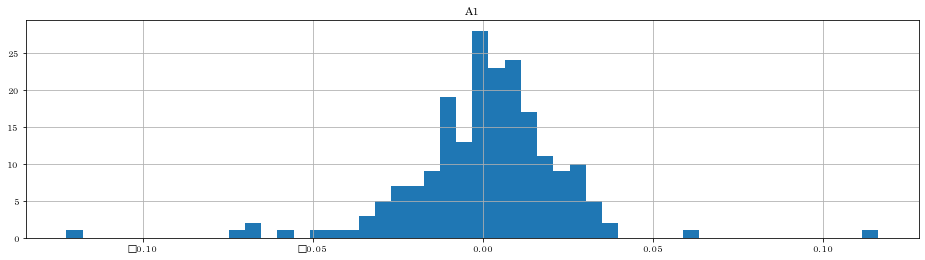

In [83]:
by_author_df.loc[by_author_df['author']=='오동환'][['A1']].hist(bins=50)

In [84]:
analyst1 = by_author_df.loc[by_author_df['author']=='최재호'][['A1']].to_numpy().flatten()
analyst2 = by_author_df.loc[by_author_df['author']=='오동환'][['A1']].to_numpy().flatten()
comp_df = pd.DataFrame([analyst1, analyst2]).transpose()
comp_df.columns = ['최재호', '오동환']

/Users/skeem396/base38/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


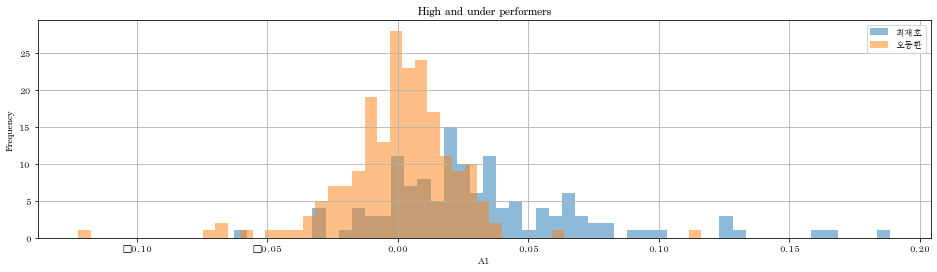

In [85]:
comp_df['최재호'].hist(alpha=0.5,bins=50, legend=True)
comp_df['오동환'].hist(alpha=0.5,bins=50, legend=True)
plt.legend()
plt.title('High and under performers')
plt.xlabel('A1')
plt.ylabel('Frequency')
# Show plot
plt.show()

/Users/skeem396/base38/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


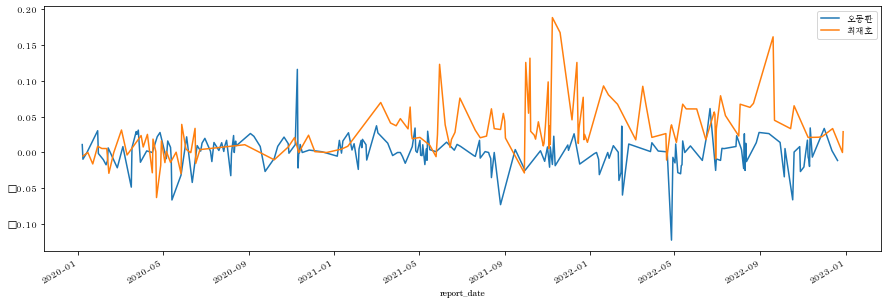

In [86]:
cnt = 0
fig, ax = plt.subplots()
leg = []
top_performers = ['오동환', '최재호']
for auth in top_performers[:5]:
    #leg.append(translator.translate(auth , src="ko", dest="en").text)
    leg.append(auth)
    tmp_df = by_author_df.loc[by_author_df['author'] == auth]
    tmp_df.set_index('report_date')['A1'].plot.line(legend=True, figsize=(15,5), ax=ax).invert_yaxis()
    cnt += 1
    #ax.set_xticklabels(list(valid_df['report_month'].unique()))
    ax.legend(leg)
    if cnt > 10:
        break

/Users/skeem396/base38/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


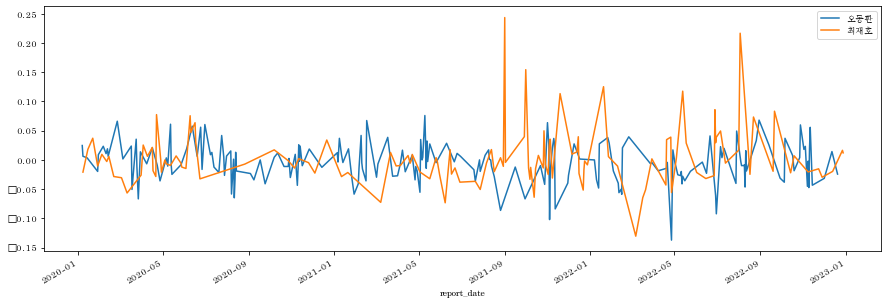

In [87]:
cnt = 0
fig, ax = plt.subplots()
leg = []
top_performers = ['오동환', '최재호']
for auth in top_performers[:5]:
    #leg.append(translator.translate(auth , src="ko", dest="en").text)
    leg.append(auth)
    tmp_df = by_author_df.loc[by_author_df['author'] == auth]
    tmp_df.set_index('report_date')['A3'].plot.line(legend=True, figsize=(15,5), ax=ax).invert_yaxis()
    cnt += 1
    #ax.set_xticklabels(list(valid_df['report_month'].unique()))
    ax.legend(leg)
    if cnt > 10:
        break

array([[<AxesSubplot:title={'center':'A2'}>]], dtype=object)

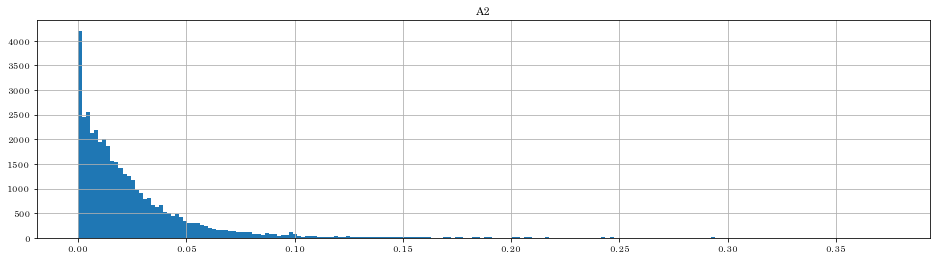

In [88]:
by_author_df[['A2']].hist(bins=200)

array([[<AxesSubplot:title={'center':'A3'}>]], dtype=object)

/Users/skeem396/base38/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


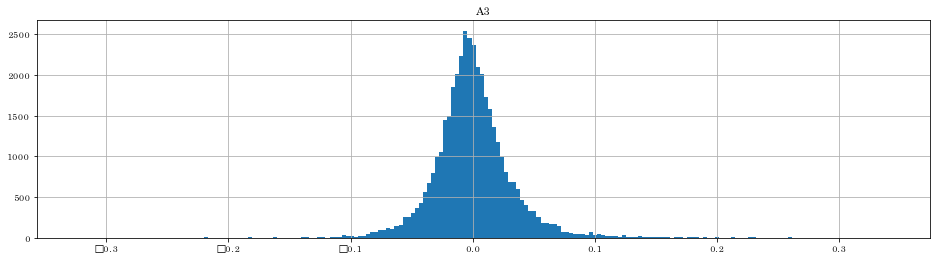

In [89]:
by_author_df[['A3']].hist(bins=200)

In [60]:
authors = by_author_df['author'].value_counts().to_dict()
authors.keys()

dict_keys(['박종선', '김장열', '김현용', '성종화', '하태기', '김경민', '김지산', '김동원', '이동욱', '정홍식', '박강호', '박종렬', '안재민', '김회재', '김홍식', '박신애', '오동환', '유재선', '강동진', '허혜민', '최민하', '양지환', '남성현', '이동헌', '이동건', '이상헌', '김현태', '박상준', '임은영', '박성봉', '유정현', '강성진', '정호윤', '김진우', '백영찬', '박세라', '권성률', '조현렬', '백재승', '최종경', '한병화', '정혜진', '김세련', '송선재', '최고운', '이상현', '어규진', '김혜미', '박혜진', '한유정', '오린아', '조미진', '서근희', '박은정', '송유림', '이화정', '전배승', '유지웅', '김인', '이기훈', '최정욱', '심은주', '김동하', '이종형', '정태준', '노우호', '이남수', '김소혜', '정동익', '홍세종', '김명주', '박성순', '오강호', '장문수', '박은경', '박유악', '이승훈', '김동양', '이진명', '하누리', '신은정', '박형우', '김현수', '이경자', '방민진', '배송이', '이동륜', '김록호', '류제현', '황성진', '강승건', '주영훈', '정용진', '김기룡', '이선화', '김장원', '김운호', '이민재', '장문준', '고의영', '문경원', '최재호', '윤재성', '조상훈', '전우제', '김진상', '박현욱', '안지영', '최관순', '장정훈', '이문종', '백두산', '김한이', '안주원', '박현진', '정원석', '성현동', '이종원', '임희연', '황현준', '한경래', '최도연', '김충현', '정연승', '이규하', '조철희', '이순학', '이경신', '김평모', '김도하', '김두현', '이민희', '황어연', '남효지', '김소원', '김정환', '김태현', '한상원', '정준섭', '신수연', '이진협', '이창

In [61]:
 by_author_df.loc[by_author_df['author'].isin([
        '박종선', '김장열', '김현용', '성종화', '하태기', '김경민', '김지산', '김동원', '이동욱', '정홍식', '박강호', '박종렬'])
                    ].set_index('report_date')[['A1']]

,A1
report_date,
2020-01-02,-0.005376
2020-01-09,0.028169
2020-01-15,-0.008772
2020-01-21,0.004310
2020-01-23,0.016824
...,...
2022-12-02,0.000859
2022-12-08,0.011080
2022-12-09,0.012821


In [62]:
by_author_df.sort_values(A1)

NameError: name 'A1' is not defined

/Users/skeem396/base38/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


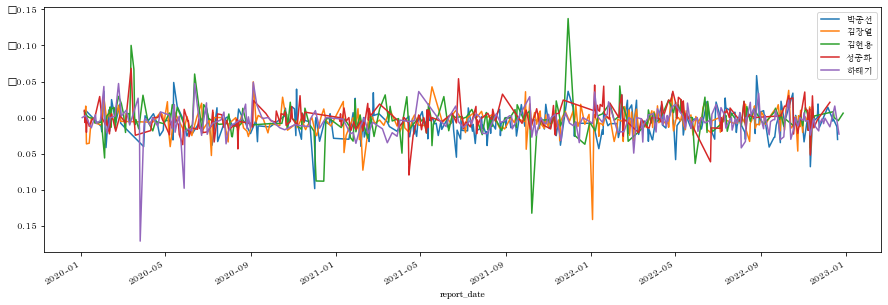

In [63]:
cnt = 0
fig, ax = plt.subplots()
leg = []
top_performers = ['박종선', '김장열', '김현용', '성종화', '하태기', '김경민', '김지산', '김동원', '이동욱', '정홍식', '박강호', '박종렬']
for auth in top_performers[:5]:
    #leg.append(translator.translate(auth , src="ko", dest="en").text)
    leg.append(auth)
    tmp_df = by_author_df.loc[by_author_df['author'] == auth]
    tmp_df.set_index('report_date')['A1'].plot.line(legend=True, figsize=(15,5), ax=ax).invert_yaxis()
    cnt += 1
    #ax.set_xticklabels(list(valid_df['report_month'].unique()))
    ax.legend(leg)
    if cnt > 10:
        break

/Users/skeem396/base38/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


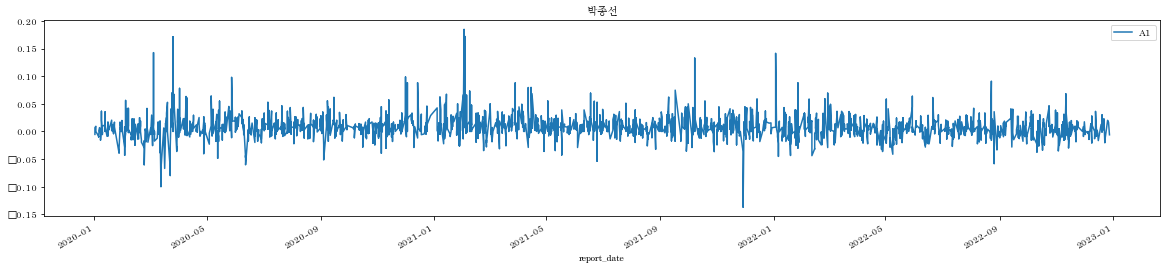

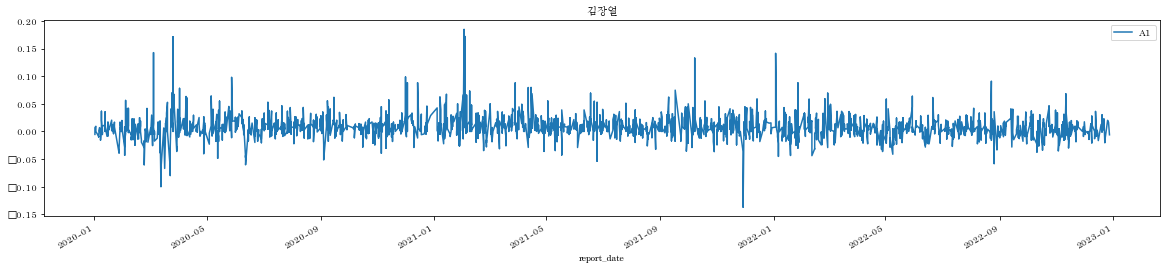

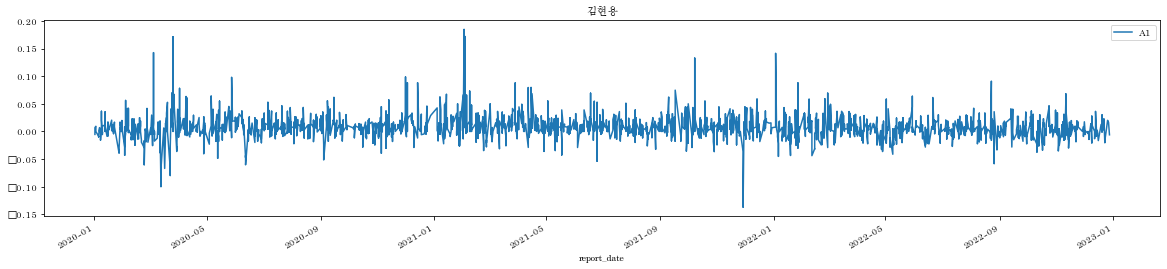

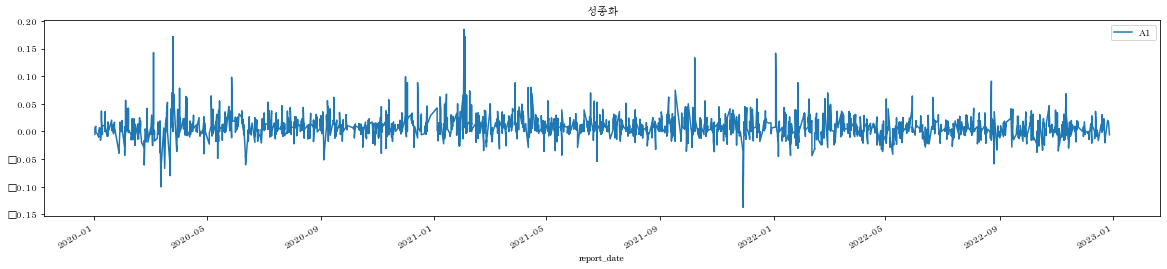

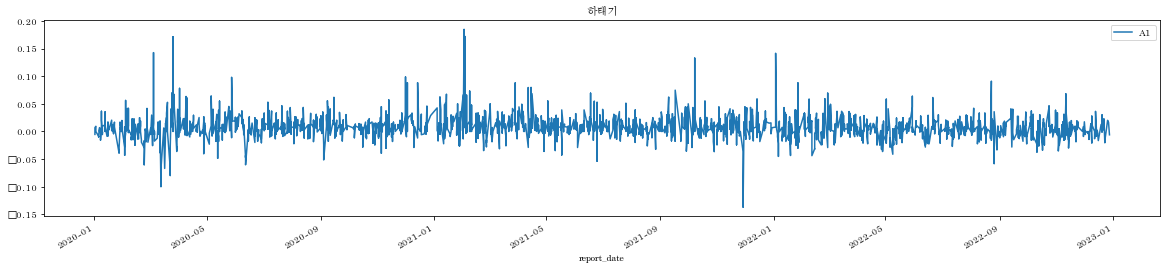

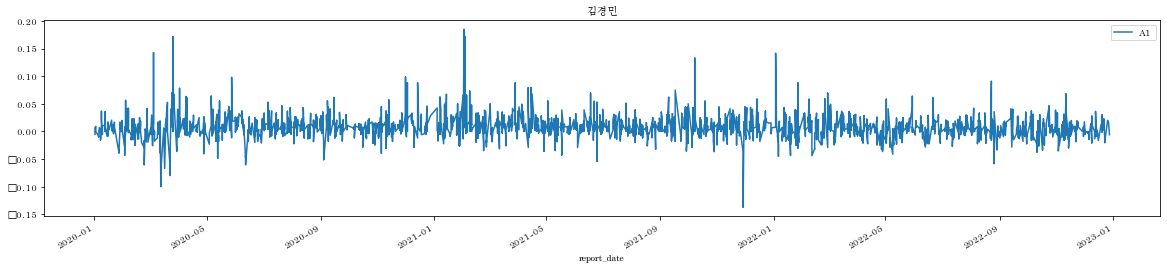

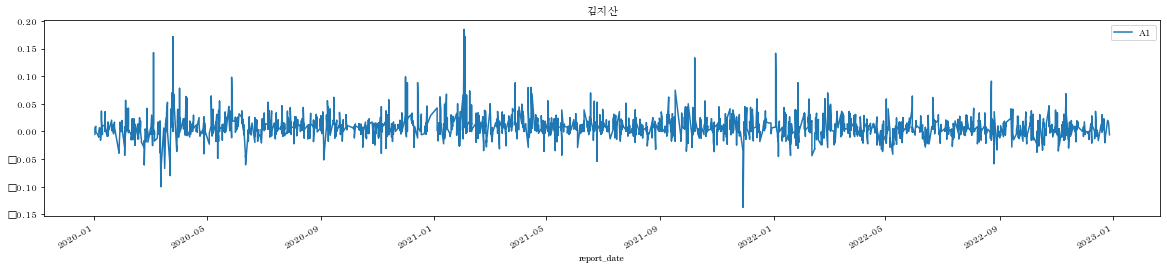

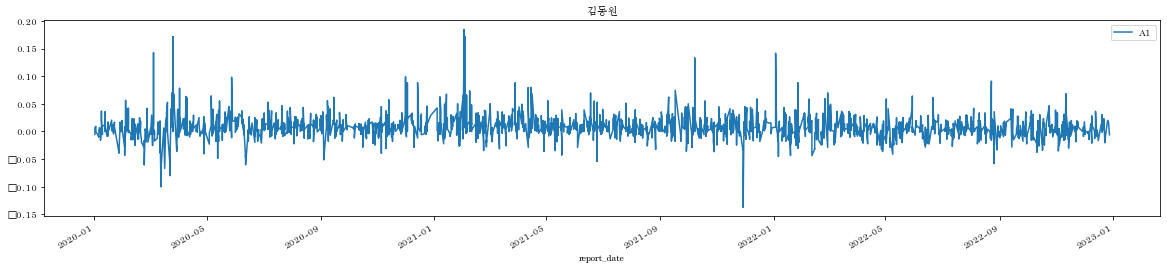

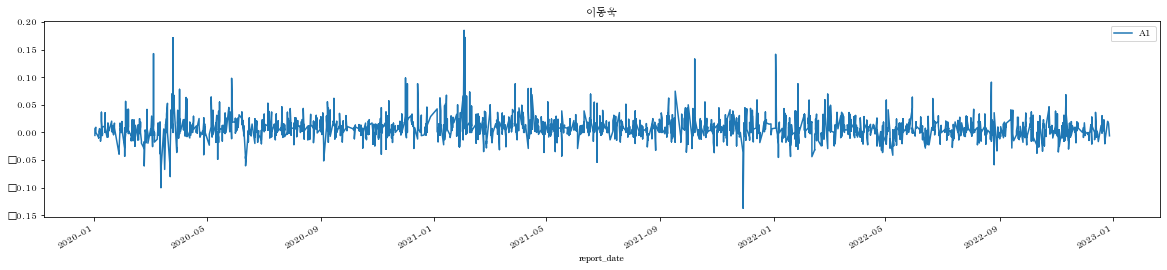

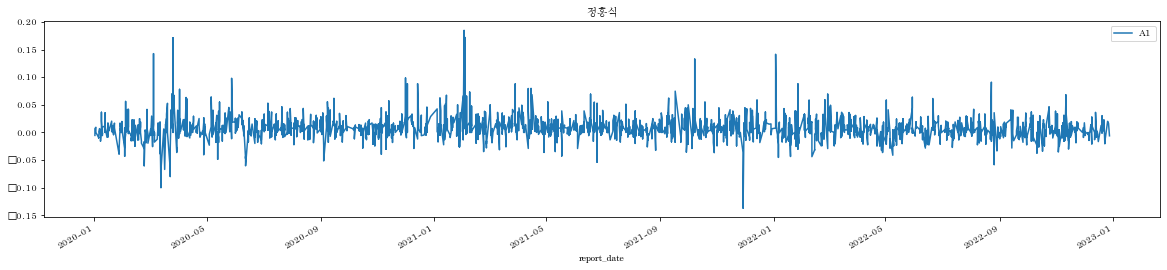

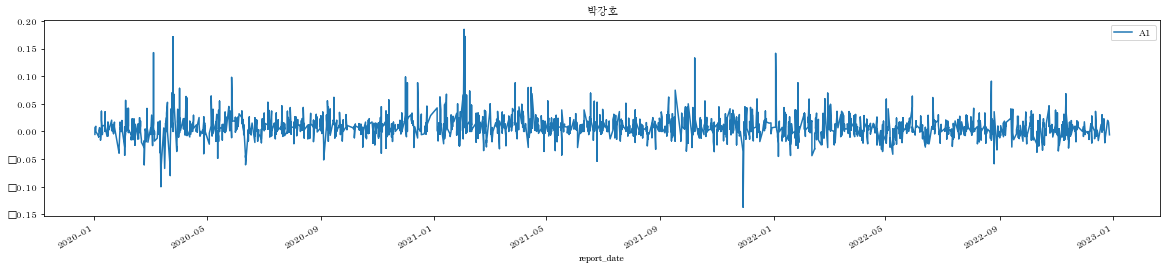

In [64]:
i = 0
for k, v in authors.items():
    by_author_df.loc[by_author_df['author'].isin([
        '박종선', '김장열', '김현용', '성종화', '하태기', '김경민', '김지산', '김동원', '이동욱', '정홍식', '박강호', '박종렬'])
                    ].set_index('report_date')[['A1']].plot(title=k, figsize=(20,4))
    i += 1
    if i > 10:
        break

In [97]:
compare_df.pivot(columns='author', index='report_date')

ValueError: Index contains duplicate entries, cannot reshape